<a href="https://colab.research.google.com/github/sp-au-mu-nl/SpeechComm/blob/main/notebook/chap10_speaker_diarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/sp-au-mu-nl/SpeechComm/raw/refs/heads/main/data/chap10.zip
!unzip -o chap10.zip
!rm chap10.zip

--2025-04-23 11:45:20--  https://github.com/sp-au-mu-nl/SpeechComm/raw/refs/heads/main/data/chap10.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sp-au-mu-nl/SpeechComm/refs/heads/main/data/chap10.zip [following]
--2025-04-23 11:45:21--  https://raw.githubusercontent.com/sp-au-mu-nl/SpeechComm/refs/heads/main/data/chap10.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20626794 (20M) [application/zip]
Saving to: ‘chap10.zip’

chap10.zip          100%[===================>]  19.67M  --.-KB/s    in 0.1s    

2025-04-23 11:45:21 (146 MB/s) - ‘chap10.zip’ saved [20626794/20626794]

Archive:  

In [2]:
!pip install tensorflow_io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 15.8 MB/s eta 0:00:00


In [3]:
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 18.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=3e16d38afe5b25f4115d0bc68b395a9fb6988497a5ef963a6a2a09fa053f21b8
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize-matplotlib


In [4]:
!pip install vad

In [5]:
%load_ext tensorboard

In [6]:
import pathlib
import os

#os.environ["KERAS_BACKEND"] = "jax"
os.environ["KERAS_BACKEND"] = "torch"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

import tensorflow as tf
import torch
#import keras_core as keras
import keras
from keras import datasets, layers, models
import tensorflow_io as tfio

import vad

from IPython import display

from tensorboard.plugins import projector

import time

import librosa

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl8str_util8EndsWithESt17basic_string_viewIcSt11char_traitsIcEES4_']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZN3tsl8str_util9LowercaseB5cxx11ESt17basic_s

In [7]:
start = time.perf_counter()

In [8]:
sample_rate = 16000
UTTERANCE_LENGTH = 2 # 10s
maxlen = tf.constant(UTTERANCE_LENGTH*sample_rate)

data_dir = pathlib.Path('data/CV_extracted/SP')

In [9]:
if not data_dir.exists():
  tf.keras.utils.get_file(
     'CV.tgz',
      origin="http://www.slp.k.hosei.ac.jp/~itou/book/2025/SpeechComm/data/CV19SPWav.tgz",
      extract=True,
      cache_dir='.', cache_subdir='data')

5158523686/5158523686 ━━━━━━━━━━━━━━━━━━━━ 236s 0us/step


In [10]:
train_files = sorted(tf.io.gfile.glob(str(data_dir) + '/train/wav/*'))

In [11]:
train_files_ds = tf.data.Dataset.from_tensor_slices(train_files)

In [12]:
df_train = pd.read_csv(str(data_dir) + '/train/metadata.csv')

In [13]:
train_label_ds = tf.data.Dataset.from_tensor_slices(pd.read_csv(str(data_dir)
      + '/train/metadata.csv').sort_values('file_name')['speaker'].to_list())

In [14]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  # audio = tfio.audio.decode_mp3(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [15]:
@tf.py_function(Tout=(tf.float32,tf.int32))
def get_waveform(file_path, label):
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)

  # vad
  waveform = waveform/np.max(np.abs(waveform))
  _wav = _vad.apply_vad(np.reshape(waveform,(1,-1)))
  waveform = tf.squeeze(_wav)

  # file_rate = tfio.audio.AudioIOTensor(tf.strings.as_string(file_path)).rate.numpy()
  # waveform = tfio.audio.resample(waveform, file_rate, sample_rate)
  return waveform, label

In [16]:
zipped_ds = tf.data.Dataset.zip((train_files_ds, train_label_ds))

In [17]:
zipped_ds = zipped_ds.shuffle(len(train_files))

In [18]:
num_all_samples = len(train_files)
num_train_samples = np.int32(num_all_samples*0.8)
num_val_samples = np.int32(num_all_samples*0.1)

In [19]:
xtrain_ds = zipped_ds.take(num_train_samples)
rest = zipped_ds.skip(num_train_samples)
xval_ds = rest.take(num_val_samples)
xtest_ds = rest.skip(num_val_samples)

In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [21]:
xtrain_waveform_ds = xtrain_ds.map(get_waveform, num_parallel_calls=AUTOTUNE)

In [22]:
def set_shape(x, y):
  return tf.ensure_shape(x, (None,)), tf.ensure_shape(y, ())

In [23]:
# xtrain_waveform_ds = xtrain_waveform_ds.map(set_shape)

In [24]:
xval_waveform_ds = xval_ds.map(get_waveform, num_parallel_calls=AUTOTUNE)
# xval_waveform_ds = xval_waveform_ds.map(set_shape)

In [25]:
xtest_waveform_ds = xtest_ds.map(get_waveform, num_parallel_calls=AUTOTUNE)
# xtest_waveform_ds = xtest_waveform_ds.map(set_shape)

In [26]:
#maxlen = max(list(xtrain_waveform_ds.map(lambda x, y: len(x), num_parallel_calls=AUTOTUNE)))

In [27]:
speakers = df_train['speaker'].unique()

In [28]:
mel_filterbank = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=50,
    num_spectrogram_bins=512//2 + 1,
    sample_rate = 16000,
    lower_edge_hertz = 100,
    upper_edge_hertz = 8000
)

In [29]:
fs = 16000

# tf.config.experimental_run_functions_eagerly(True)
tf.executing_eagerly()
_vad = vad.EnergyVAD(
    frame_length=int(512/fs*1000),
    frame_shift=int(256/fs*1000),
    pre_emphasis=0.97,
    energy_threshold=0.01,
)

In [30]:
def get_melspectrogram(waveform):
  waveform = tf.cast(waveform, tf.float32)
  if tf.shape(waveform)[0] < maxlen:
    equal_length = tf.pad(waveform, [[0, maxlen-tf.shape(waveform)[0]]])
  else:
    equal_length = waveform[:maxlen]
  #zero_padding = tf.zeros([maxlen] - tf.shape(waveform), dtype=tf.float32)
  #equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=512, frame_step=256)
  melspectrogram = tf.matmul(tf.square(tf.abs(spectrogram)), mel_filterbank)

  return melspectrogram

In [31]:
nMFCC = 30

def get_mfcc(waveform):
  waveform = tf.cast(waveform, tf.float32)
#  print(maxlen)
  if tf.shape(waveform)[0] < maxlen:
    zero_padding = tf.zeros([maxlen] - tf.shape(waveform), dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
  else:
    equal_length = waveform[:maxlen]
  spectrogram = tf.signal.stft(
      equal_length, frame_length=512, frame_step=256)
  melspectrogram = tf.matmul(tf.square(tf.abs(spectrogram)), mel_filterbank)
  log_melspectrogram = tf.math.log(melspectrogram + 1e-6)
  mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_melspectrogram)[..., :nMFCC]

  return mfccs

In [32]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  # log_spec = np.log(spectrogram.T)
  log_spec = spectrogram.T
  height = log_spec.shape[0]
  X = range(log_spec.shape[1])
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

tf.Tensor(3184, shape=(), dtype=int32)


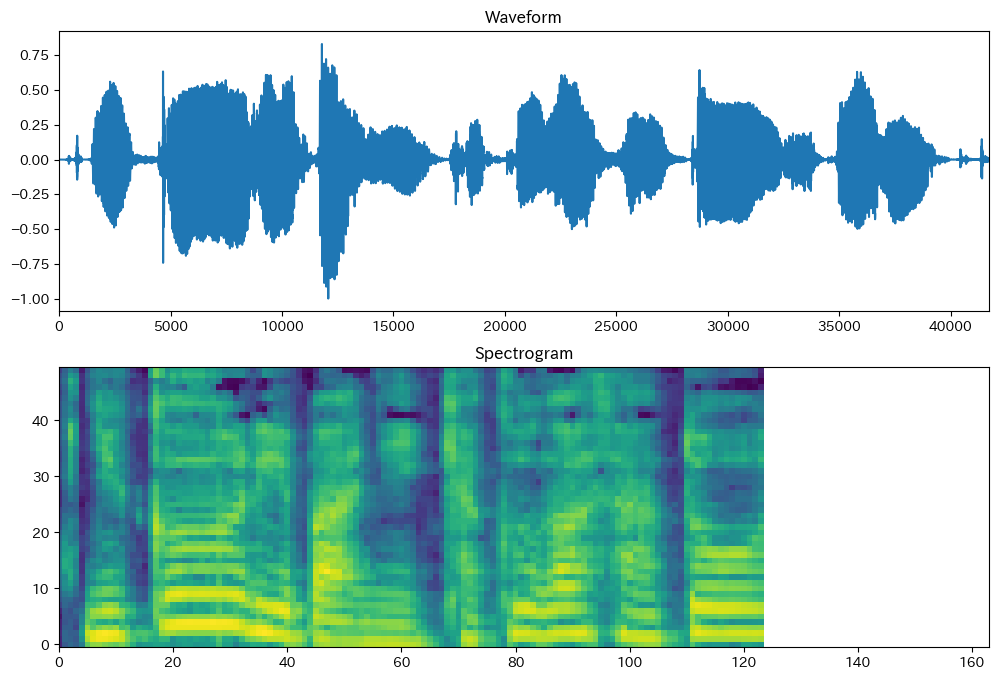

Audio playback


In [33]:
for waveform, label in xtrain_waveform_ds.take(1):
  print(label)
  spectrogram = get_melspectrogram(waveform)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_xlim(0,waveform.shape[0])
axes[0].set_title('Waveform')
plot_spectrogram(np.log(spectrogram.numpy()), axes[1])
axes[1].set_xlim(0,waveform.shape[0]/256)
axes[1].set_title('Spectrogram')
plt.show()

print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

In [34]:
def get_mfcc_and_label_id(audio, label):
  mfcc = get_mfcc(audio)
  # print(mfcc.shape)
  label_id = tf.argmax(label == speakers)
  return mfcc, label_id

In [35]:
xtrain_mfcc_ds = xtrain_waveform_ds.map(
    get_mfcc_and_label_id, num_parallel_calls=AUTOTUNE)

In [36]:
for x in xtrain_waveform_ds.take(1):
  print(x)

(<tf.Tensor: shape=(20224,), dtype=float32, numpy=
array([ 0.00013713,  0.00018284,  0.00018284, ...,  0.00557663,
       -0.00895918,  0.00726791], dtype=float32)>, <tf.Tensor: shape=(), dtype=int32, numpy=3304>)


In [37]:
for mfcc, label in xtrain_mfcc_ds.take(1):
  print(mfcc.shape)
  print(speakers[label])

(124, 30)
2672


In [38]:
xval_mfcc_ds = xval_waveform_ds.map(
    get_mfcc_and_label_id, num_parallel_calls=AUTOTUNE)

In [39]:
num_labels = len(set(train_label_ds.as_numpy_iterator()))

In [40]:
for mfcc, _ in xtrain_mfcc_ds.take(1):
  input_shape = mfcc.shape

In [41]:
batch_size = 256
EPOCHS = 6
#xtrain_mfcc_ds = xtrain_mfcc_ds.batch(batch_size)
#xval_mfcc_ds = xval_mfcc_ds.batch(batch_size)

In [42]:
#for batch, _ in xtrain_mfcc_ds.take(1):
#  batch_shape = batch.shape

In [43]:
numFilters = 256 # 512
dropProb = 0.1 # 0.2

@keras.saving.register_keras_serializable(package="MyLayers")
class StatPool1D(layers.Layer):
  def __init__(self, **kwargs):
    super(StatPool1D, self).__init__(**kwargs)

  def get_config(self):
    return super(StatPool1D, self).get_config().copy()

  def call(self, X):
    # X = X + 0.0001*np.random.uniform(size=X.shape)
    #mean = tf.math.reduce_mean(X, axis=1)
    #X = torch.from_numpy(X.numpy())
    # mean = torch.mean(X, dim=1)
    #mean = tf.convert_to_numpy(mean.numpy())
    mean = keras.ops.mean(X, axis=1)
    #std = tf.math.reduce_std(X, axis=1)
    #std = torch.std(X, dim=1)
    #std = tf.convert_to_numpy(std.numpy())
    std = keras.ops.std(X, axis=1)
    #X = tf.concat([mean, std], axis=1)
    #X = torch.cat((mean, std), 1)
    X = keras.ops.concatenate([mean, std], axis=1)
    return X

  def compute_output_shape(self, input_shape):
    return (input_shape[0], 2*input_shape[2])

####    @classmethod
#    def from_config(cls, config):
#        # Note that you can also use [`keras.saving.deserialize_keras_object`](/api/models/model_saving_apis/serialization_utils#deserializekerasobject-function) here
#        return cls(**config)
"""
model = models.Sequential([
    layers.Input(shape=input_shape),
    # layers.InputLayer(input_shape=input_shape, name='input'),
    # layers.Masking(mask_value=-0.0),
    layers.Conv1D(numFilters, 5, dilation_rate=1, activation='relu'),
    layers.Dropout(dropProb),
    layers.BatchNormalization(),
    layers.Conv1D(numFilters, 3, dilation_rate=2, activation='relu'),
    layers.Dropout(dropProb),
    layers.BatchNormalization(),
#    layers.Conv1D(numFilters, 3, dilation_rate=3, activation='relu'),
#    layers.Dropout(dropProb),
#    layers.BatchNormalization(),
#    layers.Conv1D(numFilters, 1, dilation_rate=1, activation='relu'),
#    layers.Dropout(dropProb),
#    layers.BatchNormalization(),
    layers.Conv1D(1500, 1, dilation_rate=1, activation='relu'),
    layers.Dropout(dropProb),
    layers.BatchNormalization(),
    StatPool1D(),
    layers.Dense(numFilters, name='dense1', activation='relu'),
    layers.Dropout(dropProb),
    layers.BatchNormalization(),
    layers.Dense(numFilters, activation='relu'),
    layers.Dropout(dropProb),
    layers.BatchNormalization(),
    layers.Dense(num_labels),
])

model.summary()
"""

"\nmodel = models.Sequential([\n    layers.Input(shape=input_shape),\n    # layers.InputLayer(input_shape=input_shape, name='input'),\n    # layers.Masking(mask_value=-0.0),\n    layers.Conv1D(numFilters, 5, dilation_rate=1, activation='relu'),\n    layers.Dropout(dropProb),\n    layers.BatchNormalization(),\n    layers.Conv1D(numFilters, 3, dilation_rate=2, activation='relu'),\n    layers.Dropout(dropProb),\n    layers.BatchNormalization(),\n#    layers.Conv1D(numFilters, 3, dilation_rate=3, activation='relu'),\n#    layers.Dropout(dropProb),\n#    layers.BatchNormalization(),\n#    layers.Conv1D(numFilters, 1, dilation_rate=1, activation='relu'),\n#    layers.Dropout(dropProb),\n#    layers.BatchNormalization(),\n    layers.Conv1D(1500, 1, dilation_rate=1, activation='relu'),\n    layers.Dropout(dropProb),\n    layers.BatchNormalization(),\n    StatPool1D(),\n    layers.Dense(numFilters, name='dense1', activation='relu'),\n    layers.Dropout(dropProb),\n    layers.BatchNormalization(

In [44]:
"""
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
"""

"\nmodel.compile(\n    optimizer=tf.keras.optimizers.Adam(),\n    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),\n    metrics=['accuracy'],\n)\n"

In [45]:
xtrain_mfcc_ds = xtrain_mfcc_ds.cache().prefetch(AUTOTUNE)
xval_mfcc_ds = xval_mfcc_ds.cache().prefetch(AUTOTUNE)

In [46]:
new_model = models.load_model('CV_SPKREC.keras', custom_objects={'StatPool1D': StatPool1D})
xvecsModel = models.Model(inputs=new_model.inputs,outputs=new_model.get_layer('dense1').output)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [47]:
featureShift = (512-256) / fs
segDuration = 1
segShiftDuration = 0.1
segLen = np.round(segDuration/featureShift).astype(int)
segShift = np.round(segShiftDuration/featureShift).astype(int)

In [48]:
y, fs = librosa.load('diarization_sample.wav', sr=16000)
#y, fs = librosa.load('exampleconversation.flac', sr=16000)

#maxlen = tf.constant(len(y) * 2)
seg_shift = int(segShiftDuration*fs)
waveform = None
for i in range(int(np.floor(len(y)/seg_shift))):
  if waveform is None:
    waveform = [y[:segDuration*fs]]
  elif i*seg_shift+segDuration*fs < len(y):
    waveform = np.vstack((waveform, [y[i*seg_shift:i*seg_shift+segDuration*fs]]))
  else:
    continue
#    waveform = np.vstack((waveform, [y[i*seg_shift:]]))

In [49]:
maxlen

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [50]:
len(waveform[1,:])

16000

In [51]:
mfcc = []
for i in range(waveform.shape[0]):
  mfcc.append(get_mfcc(waveform[i,:]))

In [52]:
Feature = np.array(mfcc)
Feature.shape

(144, 124, 30)

In [53]:
#mfcc_pad = mfcc[2140,:]
#mfcc = mfcc[:2138,:]

In [54]:
#Feature = []
#idx = np.arange(segLen)
#zero_padding = np.tile(mfcc_pad, (624-125,1))
#while idx[-1] < mfcc.shape[0]:
#  Feature.append(np.vstack((mfcc.numpy()[idx,:], zero_padding)))
#  idx += segShift

In [55]:
#Feature = np.array(Feature)

In [56]:
xvecs = xvecsModel.predict(Feature)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=torch.Size([32, 124, 30]))
  warnings.warn(msg)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=torch.Size([16, 124, 30]))
  warnings.warn(msg)


In [57]:
type(xvecs)

numpy.ndarray

In [58]:
xvecs.shape

(144, 256)

Text(0.5, 1.0, 'Spectrogram')

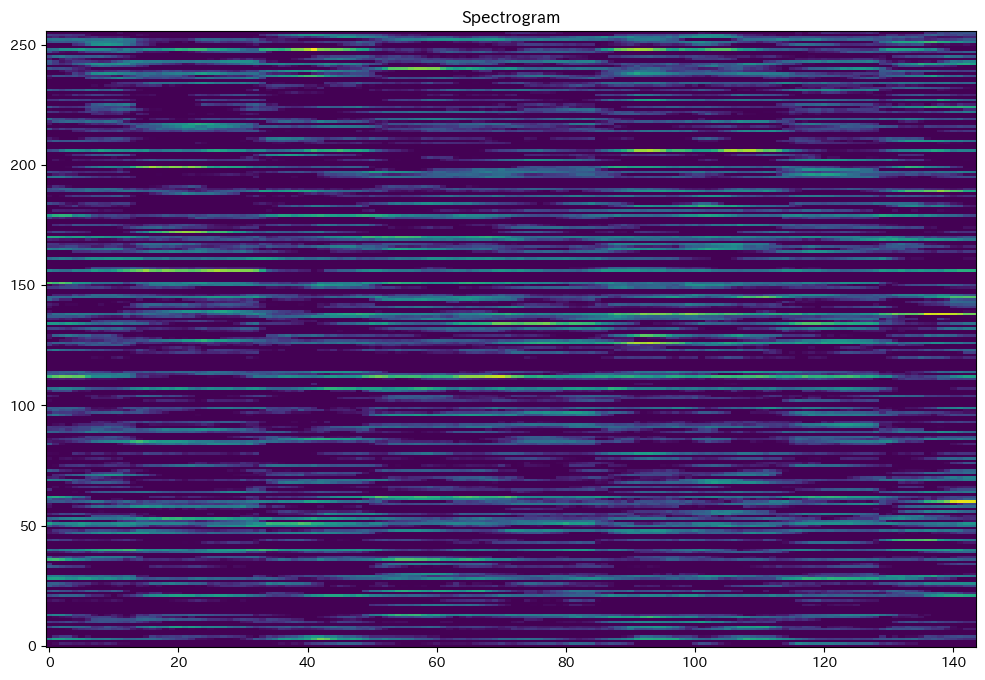

In [59]:
fig, axes = plt.subplots(1, figsize=(12, 8))
plot_spectrogram(xvecs, axes)
axes.set_title('Spectrogram')

In [60]:
clf = np.load('CVLDA.npy', allow_pickle=True).item()

In [61]:
xvecsLDA = clf.transform(xvecs)

In [62]:
np.min(xvecsLDA)

np.float32(-4.748398)

Text(0.5, 1.0, 'Spectrogram')

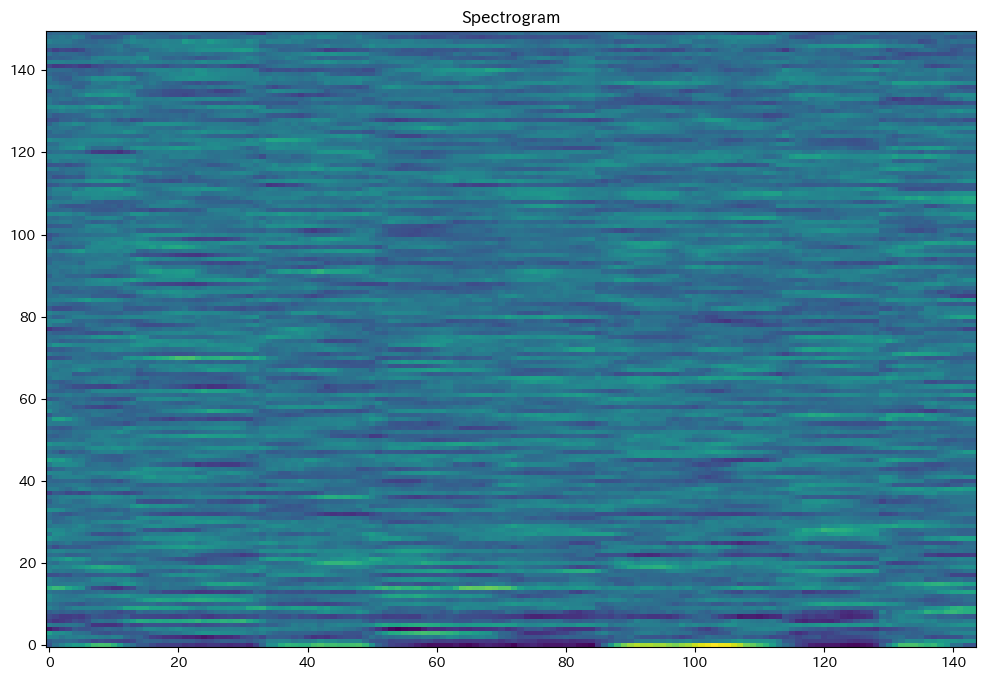

In [63]:
fig, axes = plt.subplots(1, figsize=(12, 8))
plot_spectrogram(xvecsLDA, axes)
axes.set_title('Spectrogram')

In [64]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import preprocessing

In [65]:
normalized_xvecsLDA = preprocessing.normalize(xvecsLDA)

In [66]:
normalized_xvecs = preprocessing.normalize(xvecs)

In [67]:
agg_model = AgglomerativeClustering(n_clusters=6).fit(normalized_xvecs)

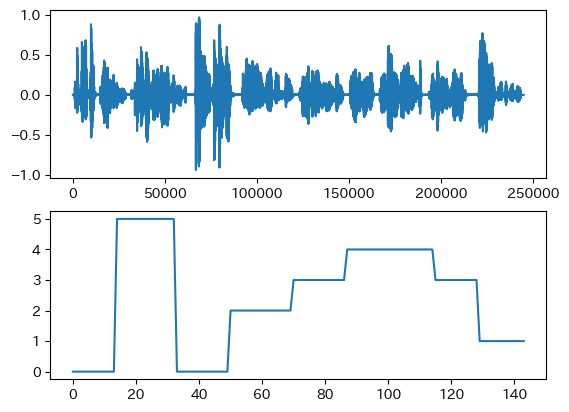

In [68]:
plt.subplot(211); plt.plot(y)
plt.subplot(212); plt.plot(agg_model.labels_)

In [69]:
kmeans_model = KMeans(n_clusters=6, random_state=0).fit(normalized_xvecsLDA)

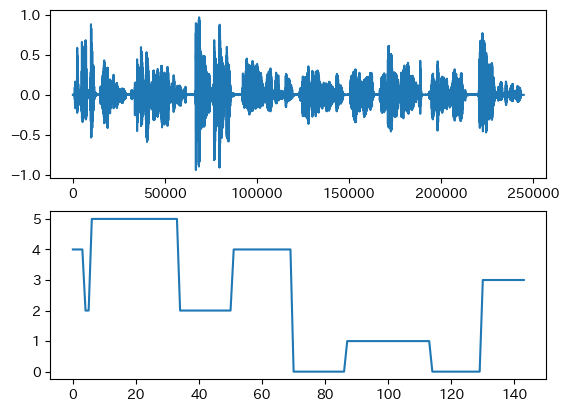

In [70]:
plt.subplot(211); plt.plot(y)
plt.subplot(212); plt.plot(kmeans_model.labels_)

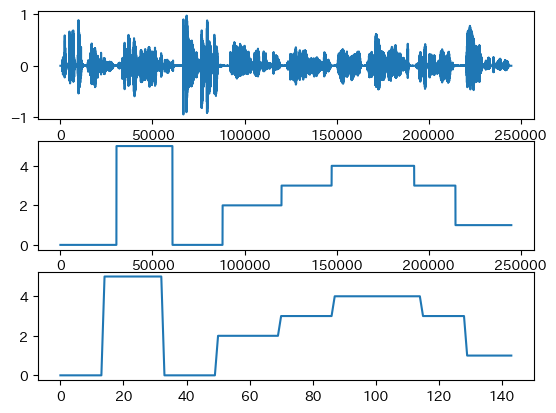

In [71]:
mask = np.zeros(len(y))
start = int(np.round((segDuration/2)*fs))

segmentShiftSamples = int(np.round(segShiftDuration*fs))

mask[:start+1] = agg_model.labels_[0]
start = start + 1
for i in range(len(agg_model.labels_)):
  finish = start + segmentShiftSamples + 1
  mask[start:finish] = agg_model.labels_[i]
  start = finish

mask[finish:] = T=agg_model.labels_[-1]
plt.subplot(311); plt.plot(y)
plt.subplot(312); plt.plot(mask)
plt.subplot(313); plt.plot(agg_model.labels_)

In [72]:
va=_vad(y/np.max(np.abs(y)))
print(len(va))
np.sum(va)

955


np.float64(715.0)

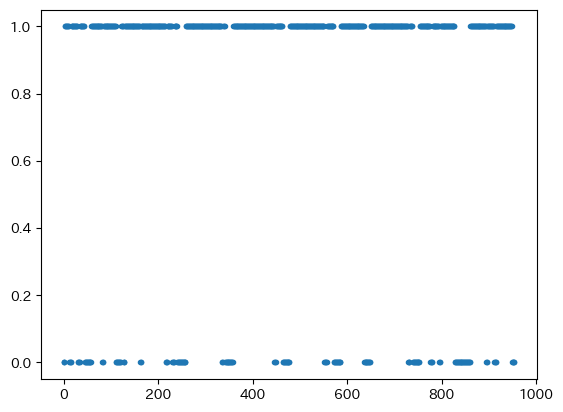

In [73]:
from scipy import signal
plt.plot(signal.medfilt(va,5),'.')

In [74]:
SILENCE_THRESHOLD_FRAMES = 10
FRAME_SHIFT = 256/fs

def identify_silence(vad, silence_threshold_frames):
  silence_beg = []; silence_end = []; sil_counter = 0

  for i, v in enumerate(vad):
    if v:
      if sil_counter > 0:
        silence_end.append(i)
        sil_counter = 0
    else:
      if sil_counter == 0:
        silence_beg.append(i)
        sil_counter += 1

  if sil_counter > 0:
    silence_end.append(i+1)

  return silence_beg, silence_end

def compute_speech_intervals(silence_beg, silence_end,
                             silence_threshold_frames,
                             FRAME_SHIFT):
  ipu_beg_ms = []; ipu_end_ms = []; sil_counter = 0

  for beg, end in zip(silence_beg, silence_end):
    if end - beg > silence_threshold_frames:
      ipu_beg_ms.append(beg * FRAME_SHIFT)
      ipu_end_ms.append(end * FRAME_SHIFT)
      sil_counter += 1
      continue
    elif beg == 0:
      ipu_beg_ms.append(0)
      ipu_end_ms.append(0)
    sil_counter = 0

  if sil_counter == 0:
    ipu_beg_ms.append(end * FRAME_SHIFT)
    ipu_end_ms.append(end * FRAME_SHIFT)

  return ipu_beg_ms, ipu_end_ms

silence_beg, silent_end = identify_silence(va, SILENCE_THRESHOLD_FRAMES)
ipu_beg_ms, ipu_end_ms = compute_speech_intervals(silence_beg, silent_end,
                                                  SILENCE_THRESHOLD_FRAMES,
                                                  FRAME_SHIFT)

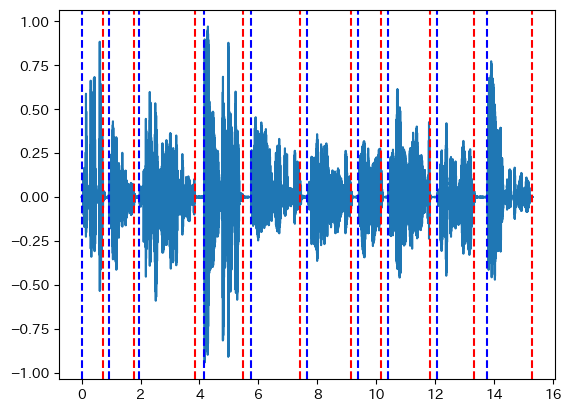

In [75]:
t=np.arange(len(y))/fs
fig, ax = plt.subplots()
plt.plot(t,y)
for i in range(len(ipu_beg_ms)):
  if i > 0:
    ax.axvline(ipu_beg_ms[i],color='r',linestyle='--')
  if i < len(ipu_end_ms)-1:
    ax.axvline(ipu_end_ms[i],color='b',linestyle='--')

In [76]:
minimum_speech_utterance = 0.4 # s

VADms = None
for beg, end in zip(ipu_beg_ms[1:], ipu_end_ms[:-1]):
  if beg - end >= minimum_speech_utterance:
    if VADms is None:
      VADms = np.array([[end,beg ]])
    else:
      VADms = np.vstack((VADms, [end,beg]))

VADms

array([[ 0.   ,  0.72 ],
       [ 0.928,  1.776],
       [ 1.952,  3.856],
       [ 4.144,  5.472],
       [ 5.744,  7.424],
       [ 7.664,  9.152],
       [ 9.392, 10.176],
       [10.4  , 11.824],
       [12.064, 13.328],
       [13.776, 15.28 ]])

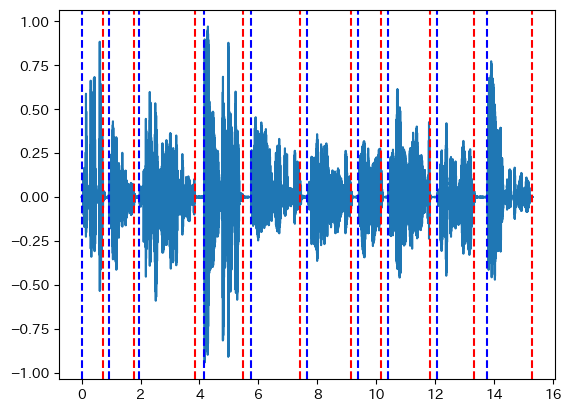

In [77]:
t=np.arange(len(y))/fs
fig, ax = plt.subplots()
plt.plot(t,y)
for i in range(len(VADms)):
    ax.axvline(VADms[i,0],color='b',linestyle='--')
    ax.axvline(VADms[i,1],color='r',linestyle='--')

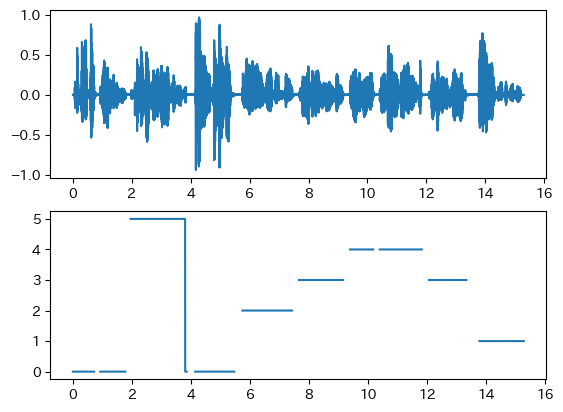

In [78]:
VADmask = np.zeros(len(y))
VADmask[:] = np.nan
for i in range(len(VADms)):
  VADmask[int(VADms[i,0]*fs):int(VADms[i,1]*fs)] = 1

mask = mask*VADmask
plt.subplot(211); plt.plot(t,y)
plt.subplot(212); plt.plot(t,mask)

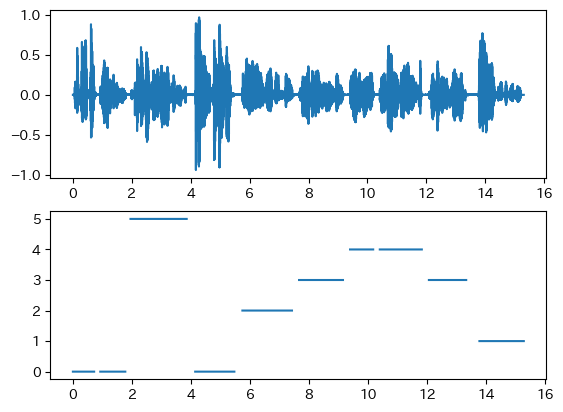

In [79]:
import scipy

maskLabels = np.zeros(len(mask))
maskLabels[:] = np.nan

for i in range(len(VADms)):
  mode, _ = scipy.stats.mode(mask[int(VADms[i,0]*fs):int(VADms[i,1]*fs)])
  maskLabels[int(VADms[i,0]*fs):int(VADms[i,1]*fs)] = mode

plt.subplot(211); plt.plot(t,y)
plt.subplot(212); plt.plot(t,maskLabels)

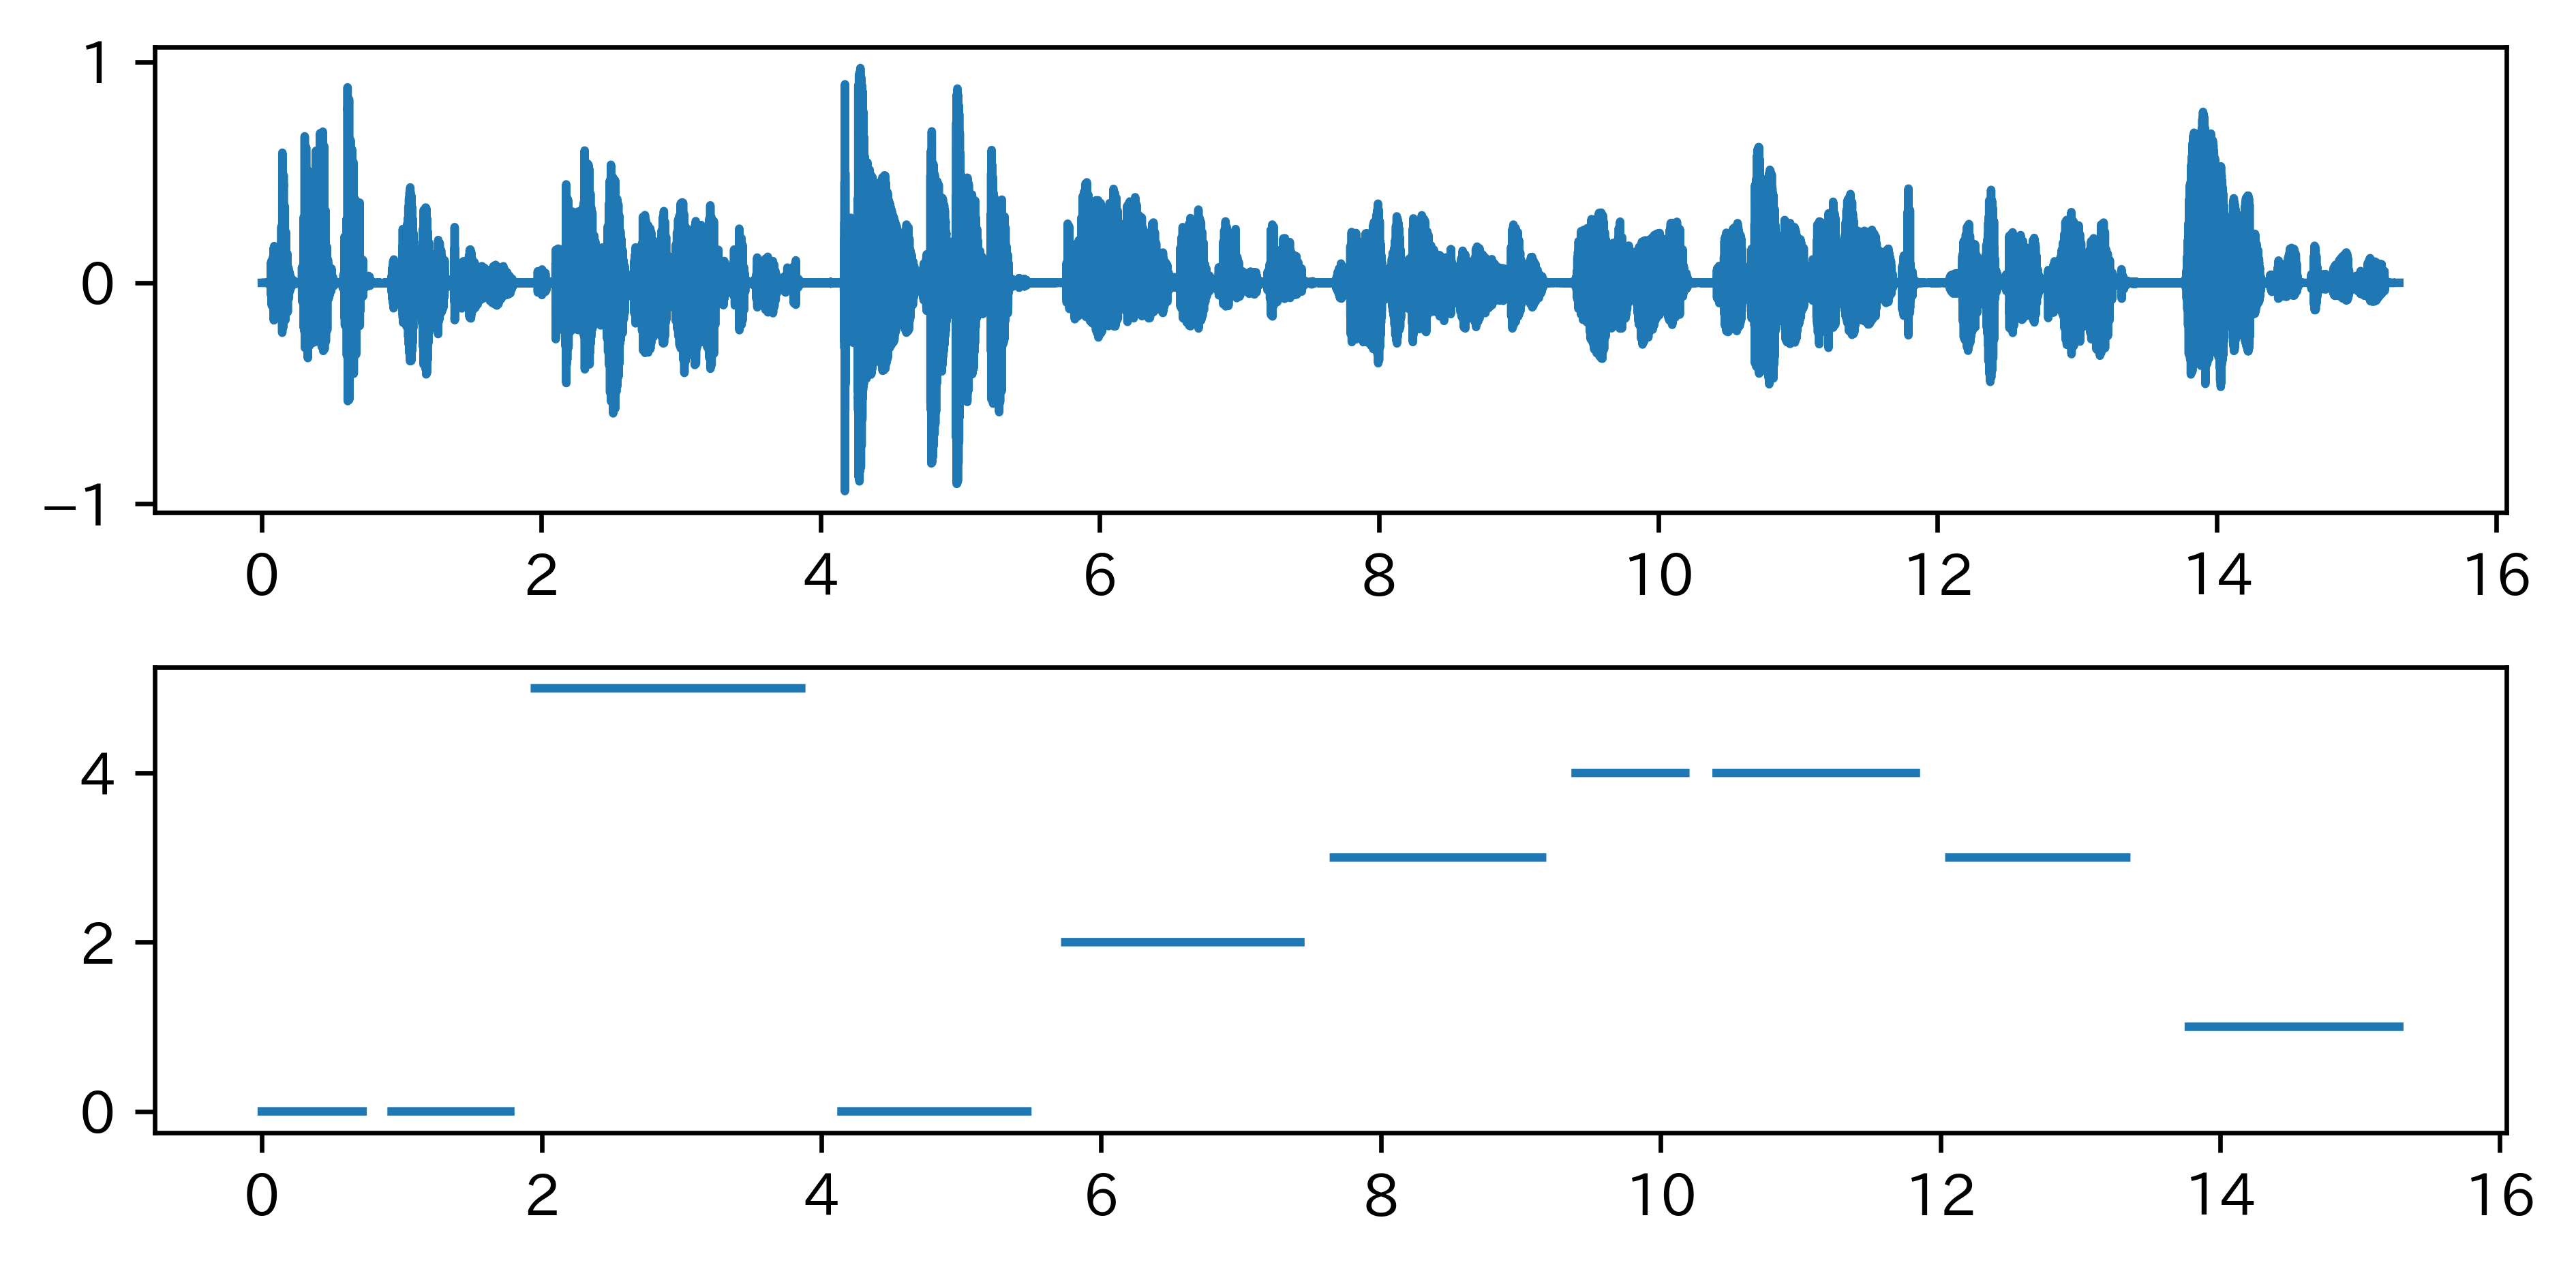

In [80]:
fig=plt.figure(1,dpi=600,figsize=(6.4,3.2),tight_layout=True)
plt.subplot(211); plt.plot(t,y)
plt.subplot(212); plt.plot(t,maskLabels)
#fig.savefig('fig10_13.eps')

In [81]:
end = time.perf_counter()
print('Elapsed time: ', end-start)

Elapsed time:  -238054.89550469


In [82]:
torch.__version__

'2.6.0+cu124'

In [83]:
tf.__version__

'2.18.0'

In [84]:
keras.__version__

'3.8.0'

In [85]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [86]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [87]:
np.__version__

'2.0.2'